In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import tessreduce as tr
from tessreduce import *

made reference
!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
made source mask
calculating background
background subtracted
aligning images


<IPython.core.display.Javascript object>


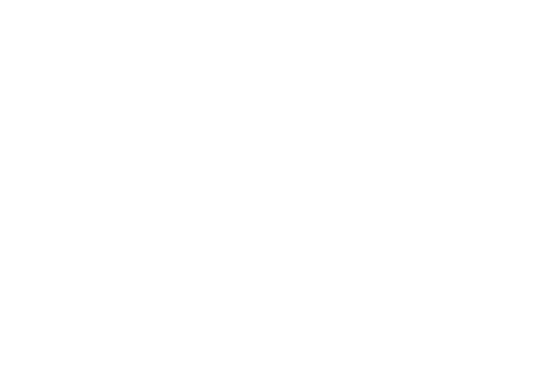

!!Re-running for difference image!!
shifting images
remade mask
background
background correlation correction
field calibration
target is above -30 dec, calibrating to PS1 photometry.


<IPython.core.display.Javascript object>


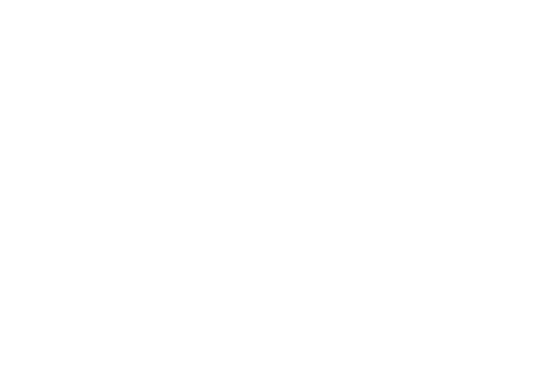

<IPython.core.display.Javascript object>


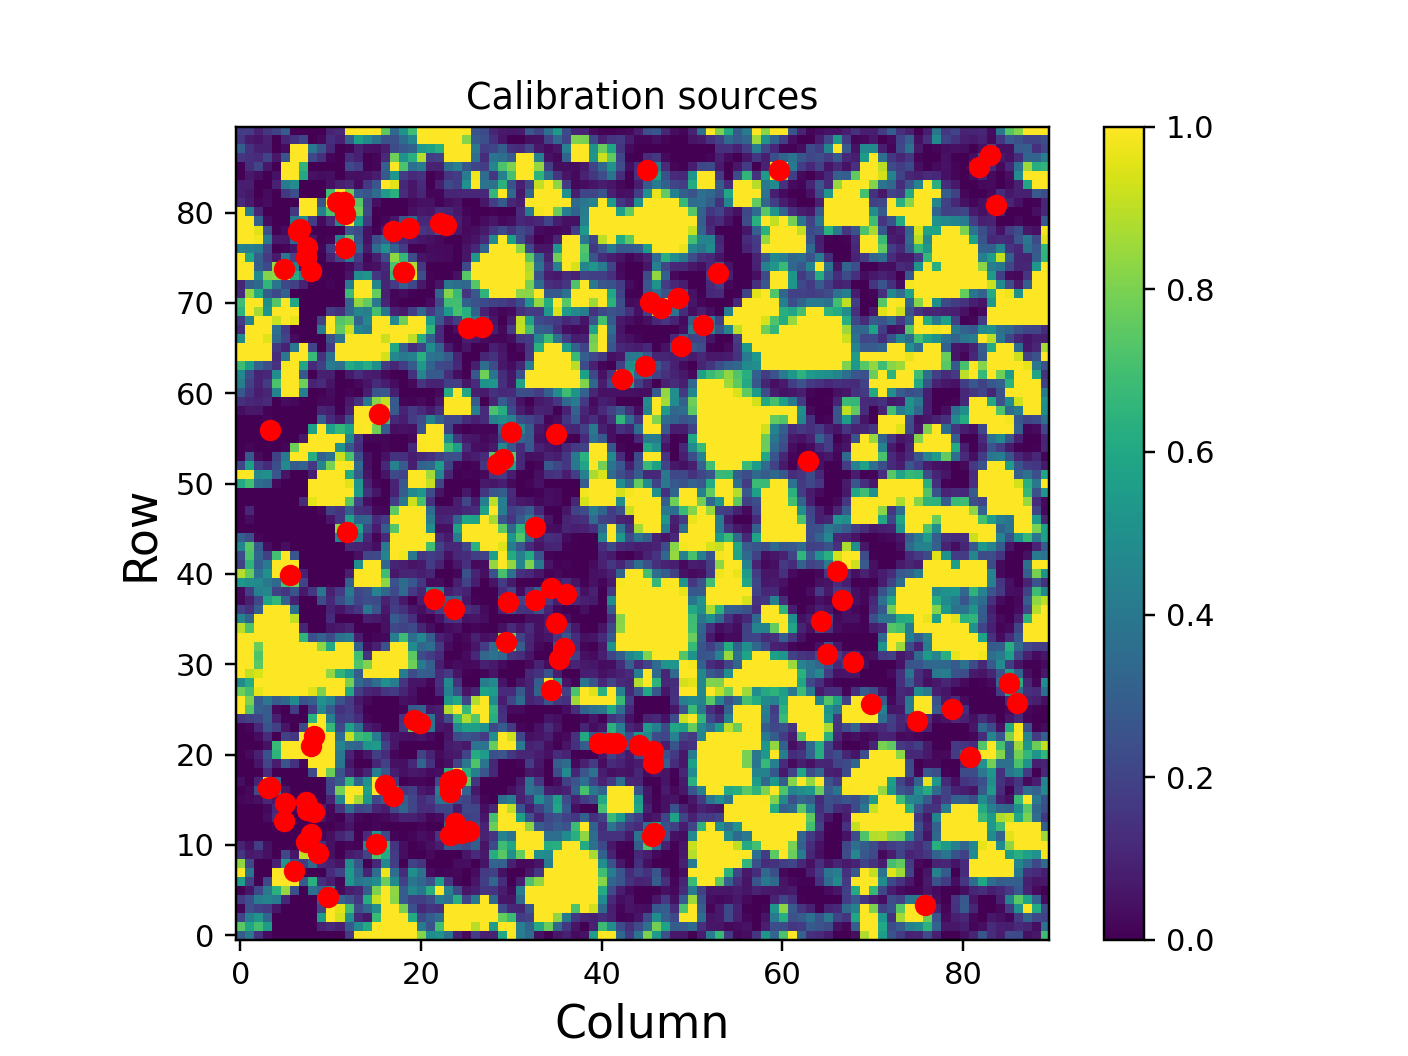

<IPython.core.display.Javascript object>


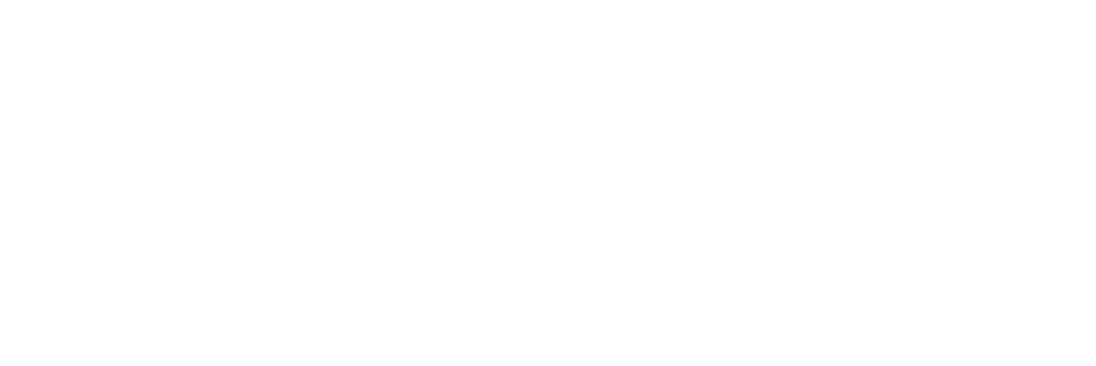

<IPython.core.display.Javascript object>


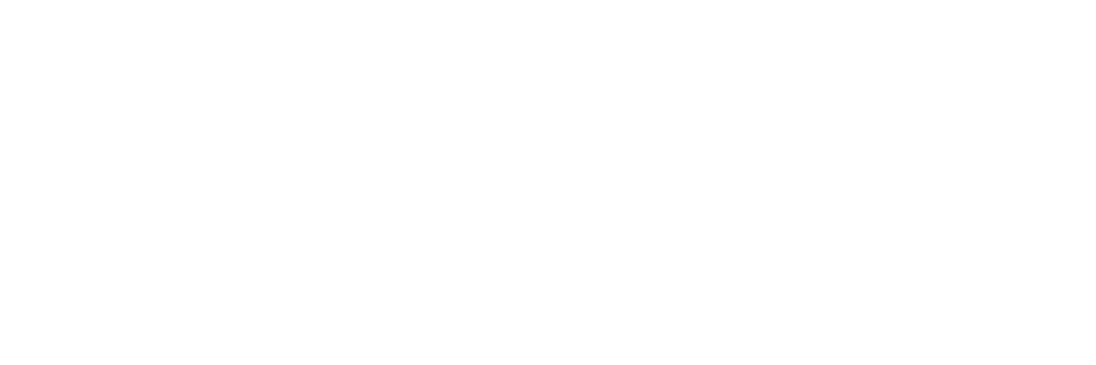

In [2]:
tess = tr.tessreduce(tpf='/Users/rri38/Documents/work//data/sn/sn2019vxm/tess/2019vxm_s18.fits',diagnostic_plot=True,phot_method='aperture',calibrate=True)


In [3]:
self = deepcopy(tess)

target is above -30 dec, calibrating to PS1 photometry.


<IPython.core.display.Javascript object>


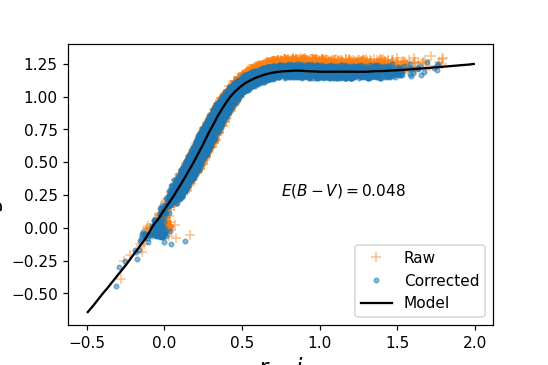

In [175]:
plot = True
savename = None
if plot is None:
    plot = self.diagnostic_plot
if savename is None:
    savename = self.savename
if self.dec < -30:
    if self.verbose > 0:
        print('target is below -30 dec, calibrating to SkyMapper photometry.')
    table = tr.Get_Catalogue(self.tpf,Catalog='skymapper')
    table = tr.Skymapper_df(table)
    system = 'skymapper'
else:
    if self.verbose > 0:
        print('target is above -30 dec, calibrating to PS1 photometry.')
    table = tr.Get_Catalogue(self.tpf,Catalog='ps1')
    system = 'ps1'
x,y = self.wcs.all_world2pix(table.RAJ2000.values,table.DEJ2000.values,0)
table['x'] = x
table['y'] = y
self.cat = table


ref = deepcopy(self.ref)
m = ((self.mask & 1 == 0) & (self.mask & 2 == 0) ) * 1.
m[m==0] = np.nan
ref_bkg = np.nanmedian(ref * m)

ref -= ref_bkg
if self.diff:
    tflux = self.flux + ref
else:
    tflux = self.flux


ind = (table.imag.values < 19) & (table.imag.values > 12)
tab = table.iloc[ind]

e, dat = tr.Tonry_reduce(tab,plot=plot,savename=savename,system=system)
self.ebv = e[0]

dat = dat.sort_values(by=['imag'], ascending=True)
pos_ind = ((1 < dat['x'].values) & (dat['x'].values < self.ref.shape[0]-2) & 
           (1 < dat['y'].values) & (dat['y'].values < self.ref.shape[0]-2))

dat = dat.iloc[pos_ind]
self.cat = dat

gr = (dat.gmag - dat.rmag).values
ind = (gr < 1) & (dat.imag.values < 17)
d = dat.iloc[ind]

x,y = self.wcs.all_world2pix(d.RAJ2000.values,d.DEJ2000.values,0)
d['col'] = x
d['row'] = y


# account for crowding 
for i in range(len(d)):
    x = d.col.values[i]
    y = d.row.values[i]

    dist = np.sqrt((tab.x.values-x)**2 + (tab.y.values-y)**2)

    ind = dist < 1.5
    close = tab.iloc[ind]

    d['gmag'].iloc[i] = -2.5*np.log10(np.nansum(mag2flux(close.gmag.values,25))) + 25
    d['rmag'].iloc[i] = -2.5*np.log10(np.nansum(mag2flux(close.rmag.values,25))) + 25
    d['imag'].iloc[i] = -2.5*np.log10(np.nansum(mag2flux(close.imag.values,25))) + 25
    d['zmag'].iloc[i] = -2.5*np.log10(np.nansum(mag2flux(close.zmag.values,25))) + 25
    if system == 'ps1':
        d['ymag'].iloc[i] = -2.5*np.log10(np.nansum(mag2flux(close.ymag.values,25))) + 25

In [201]:
x = dat.x.values; y = dat.y.values
dist = np.sqrt((x[:,np.newaxis] - x[np.newaxis,:])**2 + (y[:,np.newaxis] - y[np.newaxis,:])**2)
dist[dist==0] = np.nan
mag = dat.imag.values
dmag = mag[:,np.newaxis] - mag[np.newaxis,:]
dmag = dmag > 3
dist[dmag] = np.nan
#dist[dist<=0.2] = np.nan

In [202]:
isolated = (np.nanmin(dist,axis=1) > 1.5) & (mag < 15) & (dat['locus'].values) & (mag > 12)
dat['cal_source'] = isolated

In [203]:
dat = PS1_to_TESS_mag(dat,ebv=self.ebv)

In [208]:
self.phot_method = 'aperture'

In [210]:
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

In [214]:
xx = d.x.values[i]; yy = d.y.values[i]
ap = CircularAperture((xx,yy),1.5)
tab = aperture_photometry(tflux[100], ap)

In [221]:
tab

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,71.95177568929782,56.67398706740347,547.0088303015145


0 0.0258309205463938
1 0.08203382659625902
2 -0.21350025609222278
3 -1.3411858509273937
bad
4 0.47854688489960395
5 -0.682400599547929
bad
6 -0.21599852780000894
7 0.32417840207039283
8 nan
9 0.025840863973558115
10 0.0044499154110262396
11 0.32060776925964163
12 -0.648328039163788
bad
13 0.4210668853781563
14 0.9052773524574214
15 0.060209383045579656


<IPython.core.display.Javascript object>


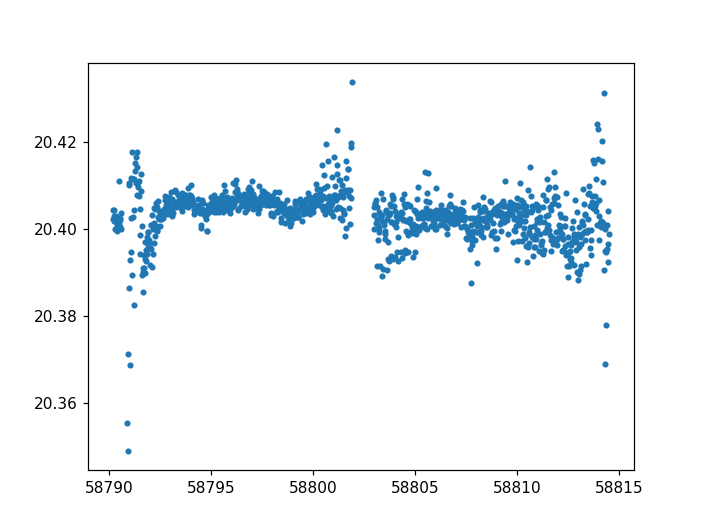

In [248]:
zp_single=False
d = dat.iloc[dat['cal_source'].values]
flux = []
eflux = []
eind = np.zeros(len(d))
for i in range(len(d)):
    mask = np.zeros_like(self.ref)
    xx = int(d.x.values[i] + .5); yy = int(d.y.values[i] + .5)
    x = d.x.values[i]; y = d.y.values[i]
    mask[yy,xx] = 1
    mask = convolve(mask,np.ones((3,3)))
    if self.phot_method == 'aperture':
        ap = CircularAperture((x,y),2)
        f = []
        for frame in tflux:
            tab = aperture_photometry(frame, ap)
            f += [tab['aperture_sum'].value]
        f = np.array(f).flatten()
        flux += [f]
        #flux += [np.nansum(tflux*mask,axis=(1,2))]
    elif self.phot_method == 'psf':
        flux += [self.psf_photometry(xPix=xx,yPix=yy,snap='ref',diff=False)]
    m2 = np.zeros_like(self.ref)
    m2[yy,xx] = 1
    m2 = convolve(m2,np.ones((7,7))) - convolve(m2,np.ones((5,5)))
    eflux += [np.nansum(tflux*m2,axis=(1,2))]
    mag = -2.5*np.log10(np.nansum((ref*mask))) + 20.44
    print(i,mag-d.tmag.values[i])
    if ((mag - d.tmag.values[i]) < -0.5):# | (mag <= 17):
        print('bad')
        eind[i] = 1
eind = eind == 0

flux = np.array(flux)
eflux = np.array(eflux)
#eind = abs(eflux) > 20
if self.phot_method == 'aperture':
    flux[~eind] = np.nan


#calculate the zeropoint
zp = d.tmag.values[:,np.newaxis] + 2.5*np.log10(flux)
mzp = np.zeros_like(zp[0]) * np.nan
stdzp = np.zeros_like(zp[0]) * np.nan
for i in range(zp.shape[1]):
    mean, med, std = sigma_clipped_stats(zp[eind,i], sigma=3.0)
    mzp[i] = med#averager.mean
    stdzp[i] = std#averager.stdev
mean, med, std = sigma_clipped_stats(mzp[np.isfinite(mzp)], sigma=2.0)

if zp_single:
    mzp = med#averager.mean
    stdzp = std#averager.stdev
    compare = abs(mzp-20.44) > 2

else:
    zp = np.nanmedian(zp,axis=0)
    mzp,stdzp = smooth_zp(zp, self.tpf.time.mjd)
    compare = (abs(mzp-20.44) > 2).any()

<IPython.core.display.Javascript object>


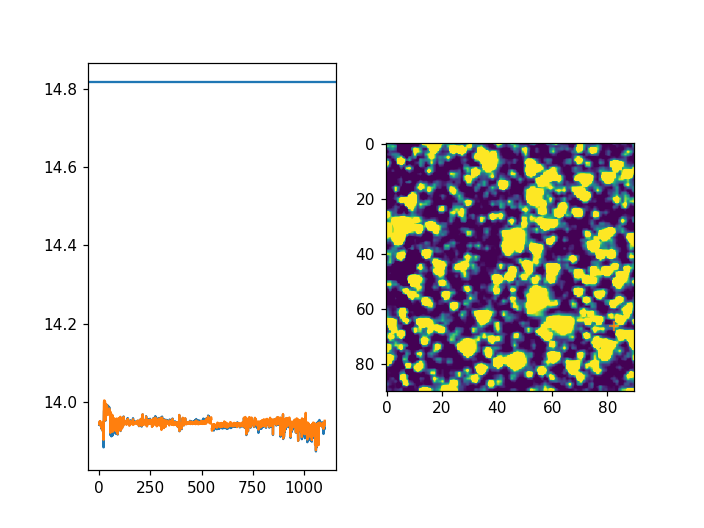

In [265]:
i = 10
plt.figure()
plt.subplot(121)
plt.plot(-2.5*np.log10(flux[i])+mzp)
plt.plot(-2.5*np.log10(flux[i])+med)
plt.axhline(d.tmag.iloc[i])
plt.subplot(122)
plt.imshow(self.ref,vmin=0,vmax=50)
plt.plot(d.x.iloc[i],d.y.iloc[i],'C1+')

In [250]:
d.tmag.iloc[0]

13.47368576682197

<IPython.core.display.Javascript object>


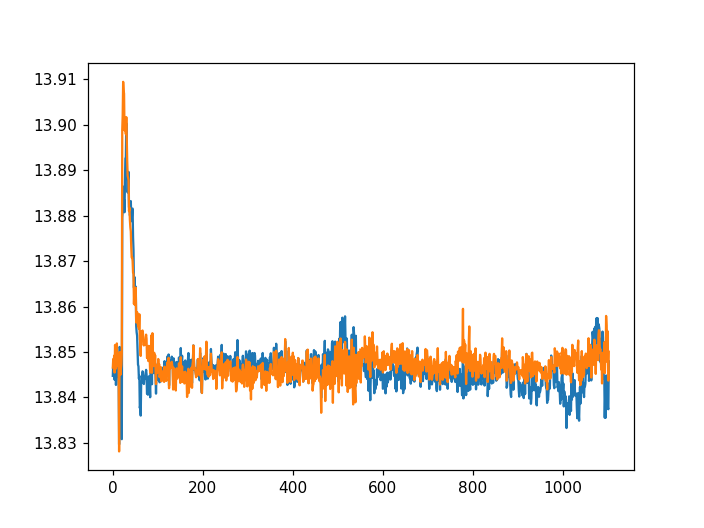

In [251]:
plt.figure()
plt.plot(-2.5*np.log10(flux[1])+mzp)
plt.plot(-2.5*np.log10(flux[1])+med)

In [252]:
med

20.40442128735507

In [253]:
std

0.0022282379813475025

<IPython.core.display.Javascript object>


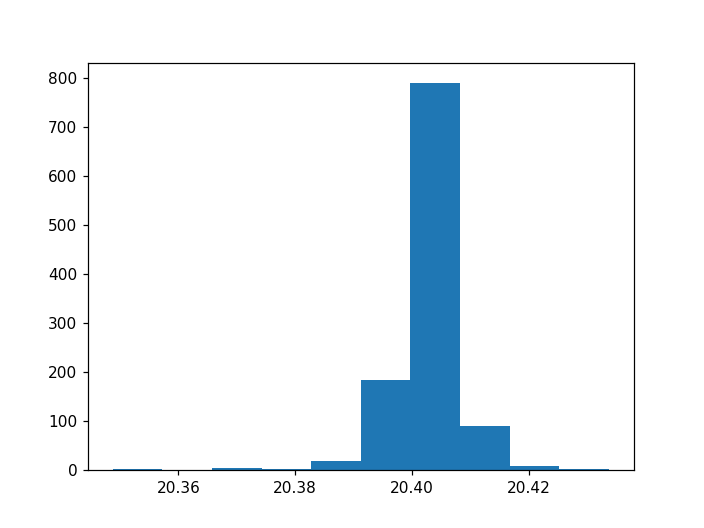

(array([  2.,   0.,   3.,   2.,  19., 184., 791.,  90.,   9.,   2.]),
 array([20.3487515 , 20.35725246, 20.36575341, 20.37425436, 20.38275532,
        20.39125627, 20.39975723, 20.40825818, 20.41675913, 20.42526009,
        20.43376104]),
 <BarContainer object of 10 artists>)

In [254]:
plt.figure()
plt.hist(zp[np.isfinite(zp)])

<IPython.core.display.Javascript object>


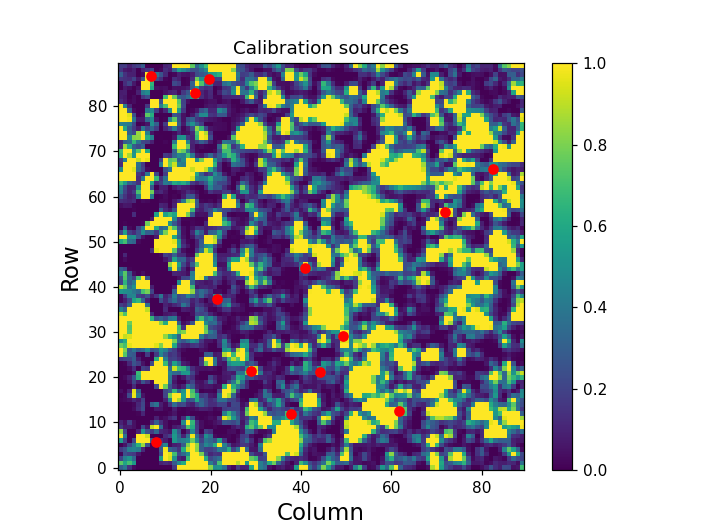

<IPython.core.display.Javascript object>


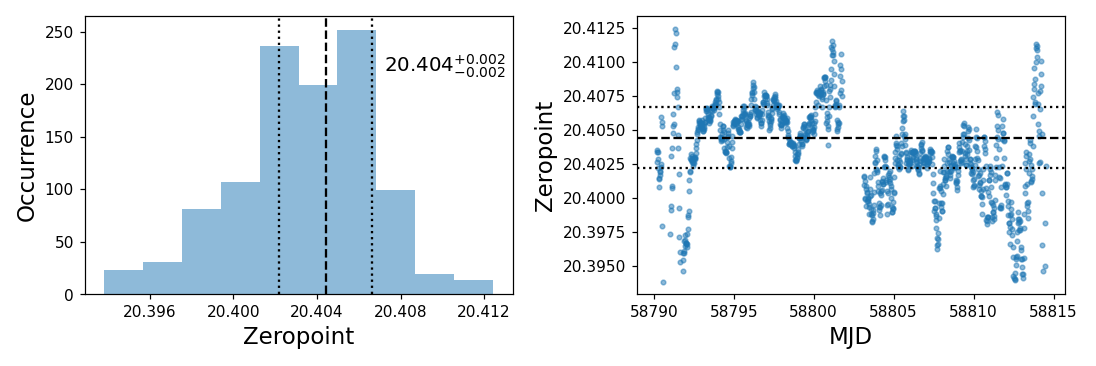

In [255]:
plt.figure()
nonan = np.isfinite(self.ref)
plt.imshow(ref,origin='lower',vmax = np.percentile(ref[nonan],80),vmin=np.percentile(ref[nonan],10))
plt.scatter(d.x.iloc[eind],d.y.iloc[eind],color='r')
plt.title('Calibration sources')
plt.ylabel('Row',fontsize=15)
plt.xlabel('Column',fontsize=15)
plt.colorbar()
plt.show()
if savename is not None:
    plt.savefig(savename + 'cal_sources.pdf', bbox_inches = "tight")


mask = sigma_mask(mzp,3)
plt.figure(figsize=(3*fig_width,1*fig_width))
plt.subplot(121)
plt.hist(mzp[mask],alpha=0.5)
#plt.axvline(averager.mean,color='C1')
#plt.axvspan(averager.mean-averager.stdev,averager.mean+averager.stdev,alpha=0.3,color='C1')
#plt.axvspan(med-std,med+std,alpha=0.3,color='C1')
med = med
low = med-std
high = med+std
plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str((np.round(med,3)))+'^{+' + str((np.round(high-med,3)))+'}_{'+str((np.round(low-med,3)))+'}$'
plt.annotate(s,(.70,.8),fontsize=13,xycoords='axes fraction')
plt.xlabel('Zeropoint',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))

plt.subplot(122)
plt.plot(self.tpf.time.mjd[mask],mzp[mask],'.',alpha=0.5)
#plt.axhspan(averager.mean-averager.stdev,averager.mean+averager.stdev,alpha=0.3,color='C1')
#plt.axhline(averager.mean,color='C1')
#plt.axhspan(med-std,med+std,alpha=0.3,color='C1')

plt.axhline(low,color='k',ls=':')
plt.axhline(high,color='k',ls=':')
plt.axhline(med,color='k',ls='--')

plt.ylabel('Zeropoint',fontsize=15)
plt.xlabel('MJD',fontsize=15)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


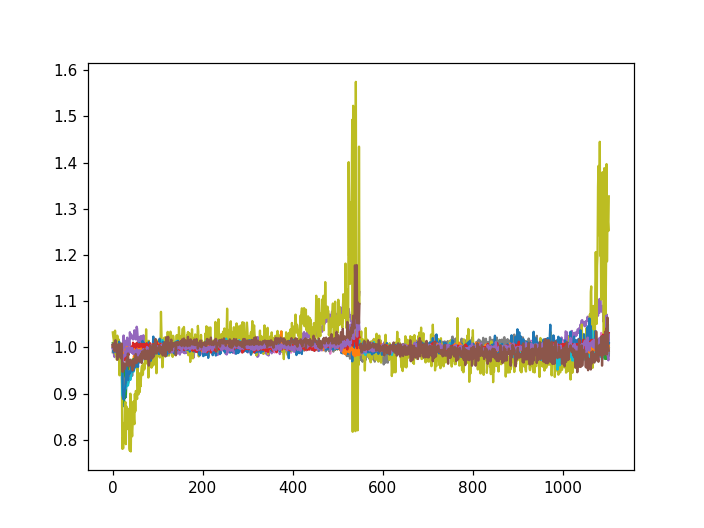

In [247]:
plt.figure()
for i in range(len(flux)):
    plt.plot(flux[i]/ np.nanmedian(flux[i]))

<IPython.core.display.Javascript object>


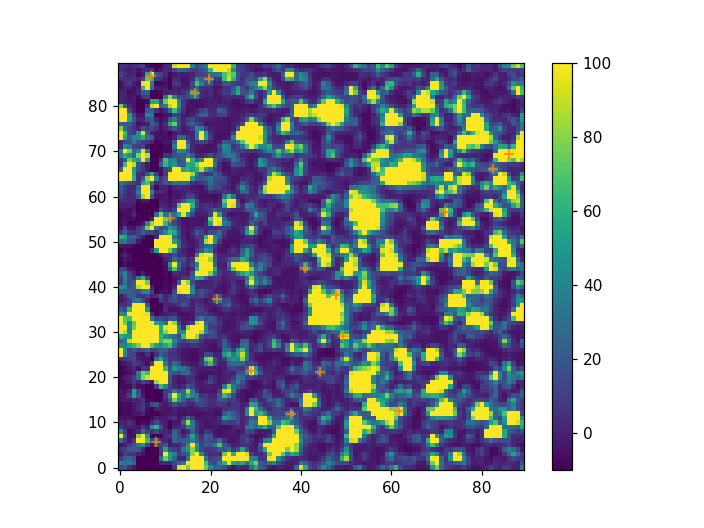

In [85]:
plt.figure()
plt.imshow(tess.ref,vmin=-10,vmax=100,origin='lower')
#plt.scatter(dat['x'],dat['y'],s=dat['imag'],c=dat['imag'],cmap='plasma')
plt.plot(dat['x'].iloc[isolated],dat['y'].iloc[isolated],'C1+')
plt.colorbar()

In [32]:
d = dat.iloc[dat['cal_source'].values]
flux = []
eflux = []
eind = np.zeros(len(d))
for i in range(len(d)):
    #if self.phot_method == 'aperture':
    mask = np.zeros_like(self.ref)
    mask[int(d.y.values[i] + .5),int(d.x.values[i] + .5)] = 1
    mask = convolve(mask,np.ones((3,3)))
    flux += [np.nansum(tflux*mask,axis=(1,2))]
    m2 = np.zeros_like(self.ref)
    m2[int(d.y.values[i] + .5),int(d.x.values[i] + .5)] = 1
    m2 = convolve(m2,np.ones((7,7))) - convolve(m2,np.ones((5,5)))
    eflux += [np.nansum(tflux*m2,axis=(1,2))]
    mag = -2.5*np.log10(np.nansum((self.ref*m2))) + 20.44
    #elif self.phot_method == 'psf':
    #	self.psf_photometry(xPix=d.col.values[i],yPix=d.row.values[i],snap=None,diff=False)

    #if (mag <= d.tmag.values[i]+1):# | (mag <= 17):
    #    eind[i] = 1
eind = eind == 0
flux = np.array(flux)
eflux = np.array(eflux)
#eind = abs(eflux) > 20
flux[~eind] = np.nan

final_d = d.iloc[eind]
final_flux = flux[eind]
zp = d.tmag.values[:,np.newaxis] + 2.5*np.log10(flux) 

In [70]:
zp

array([[20.41163568, 20.41009552, 20.41125268, ..., 20.42541599,
        20.40197294, 20.4067268 ],
       [20.35304302, 20.35150818, 20.35317369, ..., 20.35440443,
        20.35514574, 20.3518957 ],
       [20.65688517, 20.64567654, 20.64862761, ..., 20.63664389,
        20.62722848, 20.63101596],
       ...,
       [20.0155983 , 20.02450818, 20.01563236, ..., 20.08362723,
        20.06783856, 20.08900924],
       [19.53757788, 19.54298964, 19.54315728, ..., 19.54200003,
        19.55811286, 19.56838787],
       [20.3870905 , 20.36734481, 20.38714243, ..., 20.41580773,
        20.40819502, 20.38811389]])

<IPython.core.display.Javascript object>


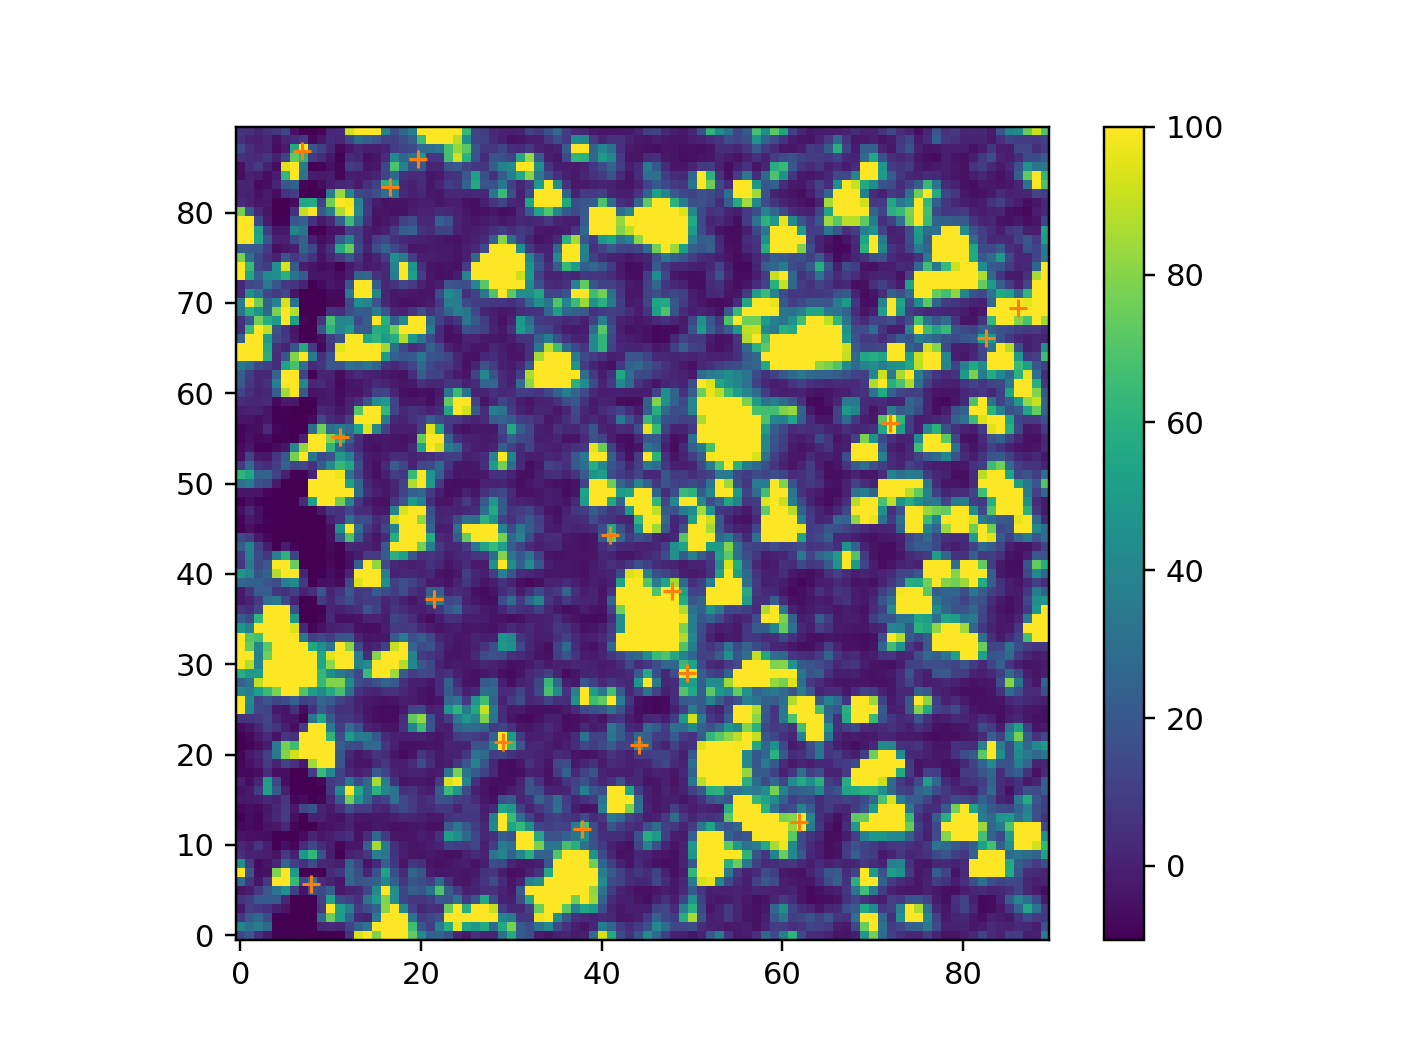